## Character-Level Generative Model

 

In [1]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import torchvision.transforms as T

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer





/Users/canerozer/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/canerozer/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/canerozer/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 56.0.0 or later, but libpng16.16.dylib provides version 54.0.0'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [19]:
import os

def load_java_files(directory_path):
    java_files = []
    
    # Iterate through all files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".java"):
            file_path = os.path.join(directory_path, filename)
            
            # Read the content of the Java file
            with open(file_path, "r", encoding="utf-8") as file:
                java_code = file.read()
                java_files.append(java_code)
    
    return java_files



In [20]:
# Specify the path to the directory containing your Java files
directory_path = '/Users/canerozer/Desktop/HW05'

# Load Java files as strings
java_code_list = load_java_files(directory_path)

In [21]:
def remove_extra_spaces0(text):
    # Remove spaces except multiple spaces at the beginning of lines
    cleaned_text = re.sub(r'(?<!\n)(?:(?<=\n)|(?<=\A))[^\S\n]+', ' ', text)
    
    cleaned_text = re.sub(r'(\n\s*)+', '\n', cleaned_text)
    
    return cleaned_text

In [22]:
def remove_extra_spaces(text):
    # Remove whitespaces except at the beginning of lines
    cleaned_text = re.sub(r'(?<!\n)[^\S\n]+', ' ', text)
    
    return cleaned_text

In [23]:
def remove_extra_spaces1(text):
    
    cleaned_text = re.sub(r'(\n\s*)+', '\n', text)
    
    return cleaned_text

In [24]:
def remove_comments1(text):
    # Remove comments in the form /* comment */
    cleaned_text = re.sub(r'/\*.*?\*/', '', text, flags=re.DOTALL)
    
    return cleaned_text

In [25]:
def remove_comments2(text):
    # Remove single-line comments in the form // comment
    cleaned_text = re.sub(r'//.*', '', text)
    
    return cleaned_text

In [26]:
def clean_text(text):
    
    text= remove_extra_spaces(text)
    text= remove_extra_spaces1(text)
    text= remove_comments1(text)
    text= remove_comments2(text)
    
    return text
    

In [44]:
cleaned_text=clean_text(java_code_list[0])
cleaned_text +=clean_text(java_code_list[1])
cleaned_text +=clean_text(java_code_list[2])
cleaned_text +=clean_text(java_code_list[3])
#cleaned_text +=clean_text(java_code_list[4])

In [45]:
#cleaned_text=re.sub(r'(\n\s*)+', '/n ', cleaned_text)
cleaned_text=cleaned_text[2:]
cleaned_text

'public class Sort {\npublic static final int NUM_ELEMENTS = 10;\n\nprivate static void swap(int[] arr, int a, int b) {\nint temp = arr[a];\narr[a] = arr[b];\narr[b] = temp;\n}\n\nprivate static int indexSmallest(int[] arr, int start) {\nint indexMin = start;\nfor (int i = start + 1; i < arr.length; i++) {\nif (arr[i] < arr[indexMin]) {\nindexMin = i;\n}\n}\nreturn indexMin;\n}\n\npublic static void selectionSort(int[] arr) {\nfor (int i = 0; i < arr.length - 1; i++) {\nint j = indexSmallest(arr, i);\nswap(arr, i, j);\n}\n}\n\npublic static void insertionSort(int[] arr) {\nfor (int i = 1; i < arr.length; i++) {\nif (arr[i] < arr[i-1]) {\n\nint toInsert = arr[i];\n\nint j = i;\ndo {\narr[j] = arr[j - 1];\nj = j - 1;\n} while (j > 0 && toInsert < arr[j-1]);\n\narr[j] = toInsert;\n}\n}\n}\n\npublic static void shellSort(int[] arr) {\n\nint incr = 1;\nwhile (2 * incr <= arr.length)\nincr = 2 * incr;\nincr = incr - 1;\n\nwhile (incr >= 1) {\nfor (int i = incr; i < arr.length; i++) {\nif (ar

In [46]:
print(f"Number of characters in my training set is {len(cleaned_text)}")

Number of characters in my training set is 14428


In [47]:
chars_in_text = sorted(list(set(cleaned_text)))

num_chars = len(chars_in_text)

print(f'There are {num_chars} characters in the text.')

print(f'Character set: {chars_in_text}.')

There are 85 characters in the text.
Character set: ['\n', ' ', '!', '"', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}'].


In [48]:
def char2int(c):
    return chars_in_text.index(c)

def int2char(i):
    return chars_in_text[i]

In [49]:
sample_len = 100

# Creating lists that will hold our input and target sample sequences

input_seq_chars = []
target_seq_chars = []

for k in range(len(cleaned_text)-sample_len+1):

    # Remove last character for input sequence
    input_seq_chars.append(cleaned_text[k:k+sample_len-1])

    # Remove firsts character for target sequence
    target_seq_chars.append(cleaned_text[k+1:k+sample_len])

for i in range(5):
    print(f'Input sequence:\n{input_seq_chars[i]}')
    print(f'Target sequence:\n{target_seq_chars[i]}')
    print()



Input sequence:
public class Sort {
public static final int NUM_ELEMENTS = 10;

private static void swap(int[] arr,
Target sequence:
ublic class Sort {
public static final int NUM_ELEMENTS = 10;

private static void swap(int[] arr, 

Input sequence:
ublic class Sort {
public static final int NUM_ELEMENTS = 10;

private static void swap(int[] arr, 
Target sequence:
blic class Sort {
public static final int NUM_ELEMENTS = 10;

private static void swap(int[] arr, i

Input sequence:
blic class Sort {
public static final int NUM_ELEMENTS = 10;

private static void swap(int[] arr, i
Target sequence:
lic class Sort {
public static final int NUM_ELEMENTS = 10;

private static void swap(int[] arr, in

Input sequence:
lic class Sort {
public static final int NUM_ELEMENTS = 10;

private static void swap(int[] arr, in
Target sequence:
ic class Sort {
public static final int NUM_ELEMENTS = 10;

private static void swap(int[] arr, int

Input sequence:
ic class Sort {
public static final int NUM_ELEM

In [50]:
input_seq = []
target_seq = []

for i in range(len(input_seq_chars)):
    input_seq.append( [char2int(ch) for ch in input_seq_chars[i]])
    target_seq.append([char2int(ch) for ch in target_seq_chars[i]])

print(input_seq[0])

[72, 77, 58, 68, 65, 59, 1, 59, 68, 57, 75, 75, 1, 45, 71, 74, 76, 1, 83, 0, 72, 77, 58, 68, 65, 59, 1, 75, 76, 57, 76, 65, 59, 1, 62, 65, 70, 57, 68, 1, 65, 70, 76, 1, 41, 47, 40, 56, 34, 39, 34, 40, 34, 41, 46, 45, 1, 28, 1, 16, 15, 26, 0, 0, 72, 74, 65, 78, 57, 76, 61, 1, 75, 76, 57, 76, 65, 59, 1, 78, 71, 65, 60, 1, 75, 79, 57, 72, 7, 65, 70, 76, 53, 55, 1, 57, 74, 74, 11]


In [51]:
# convert an integer into a one-hot encoding of the given size (= number of characters)
def int2OneHot(X,size):

    def int2OneHot1(x,size=10):
        tmp = np.zeros(size)
        tmp[int(x)] = 1.0
        return tmp

    return np.array([ int2OneHot1(x, size) for x in X ]).astype('double')


def seq2OneHot(seq,size):
    return np.array([ int2OneHot(x, size) for x in seq ])

In [52]:
# Convert our input sequences to one-hot form

input_seq = seq2OneHot(input_seq,size=num_chars)
input_seq.shape

(14329, 99, 85)

In [53]:
# Convert our target sequences to one-hot form

target_seq = seq2OneHot(target_seq,size=num_chars)
target_seq.shape

(14329, 99, 85)

In [54]:
input_seq = torch.Tensor(input_seq).type(torch.DoubleTensor)
target_seq = torch.Tensor(target_seq).type(torch.DoubleTensor)

In [55]:
class Basic_Dataset(Dataset):

    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

ds = Basic_Dataset(input_seq,target_seq)

ds.__len__()

14329

In [56]:
batch_size = 128

data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)



In [57]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [58]:
from os import device_encoding
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,dropout):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=dropout,batch_first=True)
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        hidden_state_size = x.size(0)

        x = x.to(torch.double)

        h0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)
        c0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)

        self.lstm = self.lstm.double()

        self.fc1 = self.fc1.double()

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (hx,cx) = self.lstm(x, (h0,c0))

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc1(out)

        return out

In [59]:
# Instantiate the model with hyperparameters

model = Model(input_size=num_chars, output_size=num_chars, hidden_dim=256, n_layers=1,dropout=0.0)

print(model)

model = model.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001,weight_decay=0.0)



Model(
  (lstm): LSTM(85, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=85, bias=True)
)


100%|██████████████████████████████████████████| 30/30 [53:00<00:00, 106.03s/it]


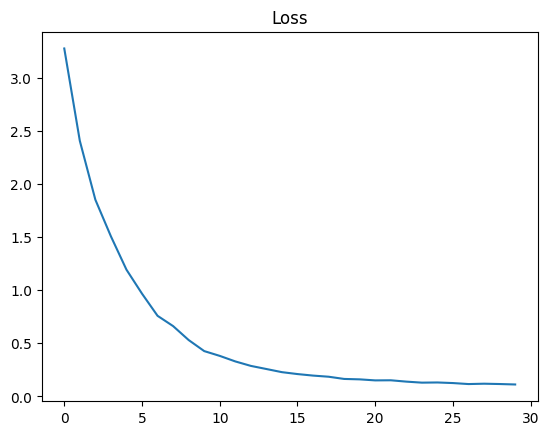

In [60]:
num_epochs = 30

losses = []

model.train()

for epoch in tqdm(range(num_epochs)):

    for input_seq_batch,target_seq_batch in data_loader:
        input_seq_batch = input_seq_batch.to(device)
        target_seq_batch = target_seq_batch.to(device)
        optimizer.zero_grad()
        target_seq_hat = model(input_seq_batch)
        loss = loss_fn(target_seq_hat,target_seq_batch.view(-1,num_chars))
        loss.backward()
        optimizer.step()
        
    losses.append(loss.item())


plt.title('Loss')
plt.plot(losses)

In [61]:
def softmax_with_temperature(vec, temperature):
    sum_exp = sum(math.exp(x/temperature) for x in vec)
    return [math.exp(x/temperature)/sum_exp for x in vec]

In [62]:
temperature = 0.3

def predict(model, ch):

    # only look at last sample_len - 1 characters

    ch = ch[-(sample_len - 1):]

    # One-hot encoding our input to fit into the model
    ch = np.array([char2int(c) for c in ch])
    ch = np.array([int2OneHot(ch, num_chars)])
    ch = torch.from_numpy(ch).to(device)

    out = model(ch)

    # take the probability distribution of the last character in the sequence produced by the model
    prob = softmax_with_temperature(out[-1],temperature)

    # Choosing a character based on the probability distribution, with temperature
    char_ind = choice(list(range(num_chars)), p=prob)

    return int2char(char_ind)

In [63]:
def sample(model, out_len, start):
    model.eval() # eval mode
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [64]:
print(sample(model, 1000, "import"))

import java.awt.Color; 
public class RecursionExamples {


private static double lengthDecrement = 0.99;
private static double sizeDecrement = 0.99; 

private static void drawSpiral(int depth) {
drawSpiralHelper(0.5, 0.5, 0.0, 0.4, 0.1, depth);
}

private static void drawSpiralHelper(double x, double y, double angle, double length, double radius, int depth) {
if(depth == 0)
return;
StdDraw.circle(x+rotateX(angle,length), y+rotateY(angle, length), radius);
drawSpiralHelper(x,y, angle+0.1, length*lengthDecrement, radius*sizeDecrement, depth-1);
}
private static double rotateX(double angle, double length) {
return length * Math.cos(angle); 
}
private static double rotateY(double angle, double length) {
return length * Math.cos(angle); 
}
private static double rotateY(double angle, double length) {
return length * Math.cos(angle); 
}
private static double rotateY(double angle, double length) {
return length * Math.cos(angle); 
}
private static double rotateY(double angle, double length) {


### My analysis


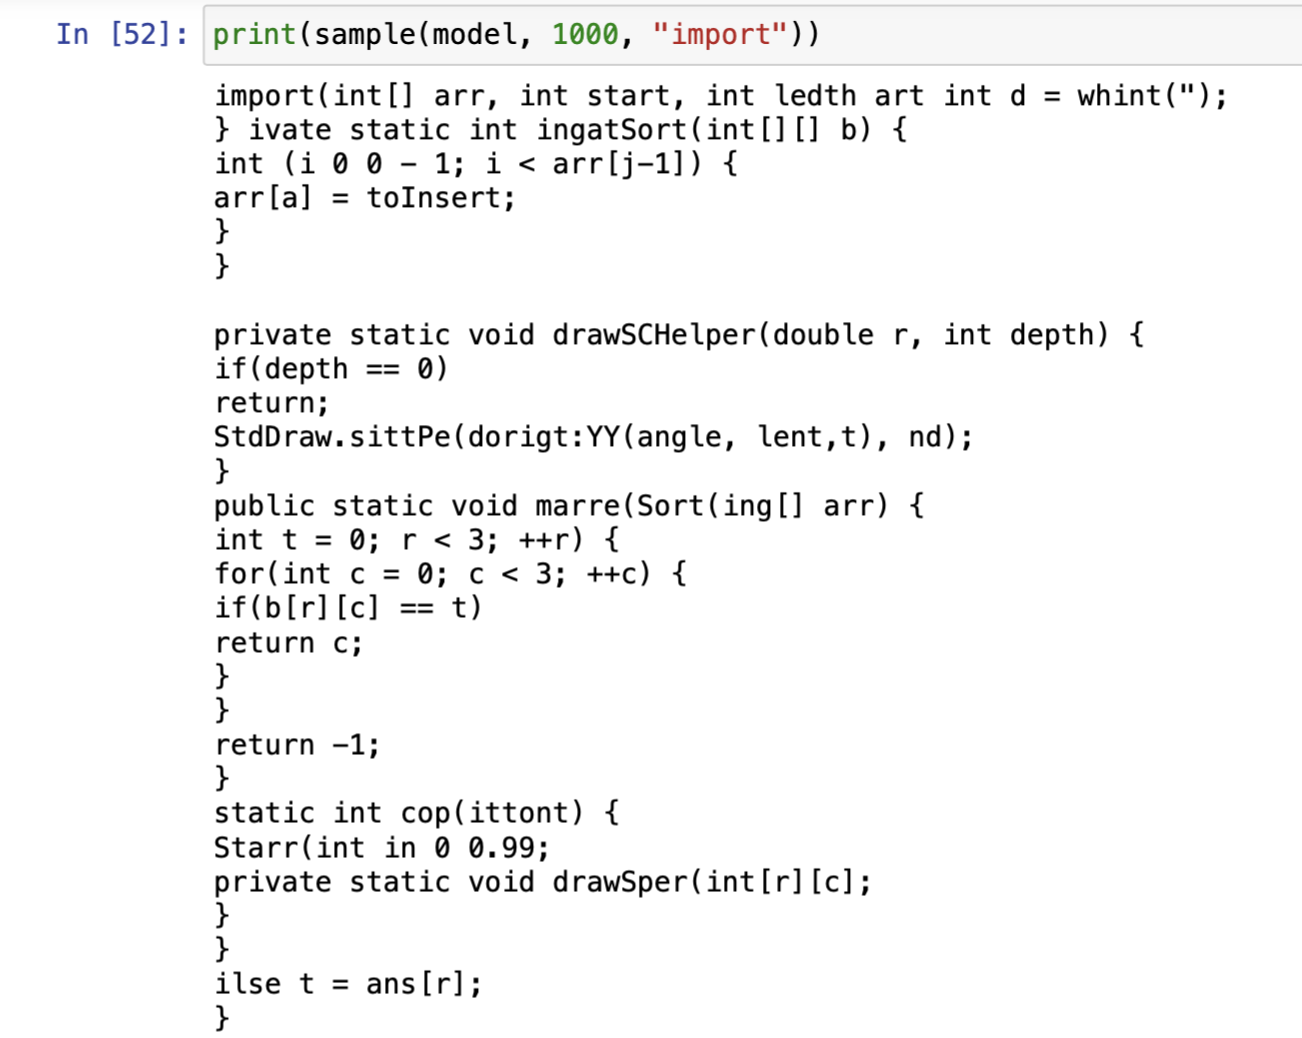

In [66]:
from IPython.display import Image
path='/Users/canerozer/Desktop/cs505_hw5_ss/'
Image(filename=path+'10_epoch;len11997;lr=0.001.png') 

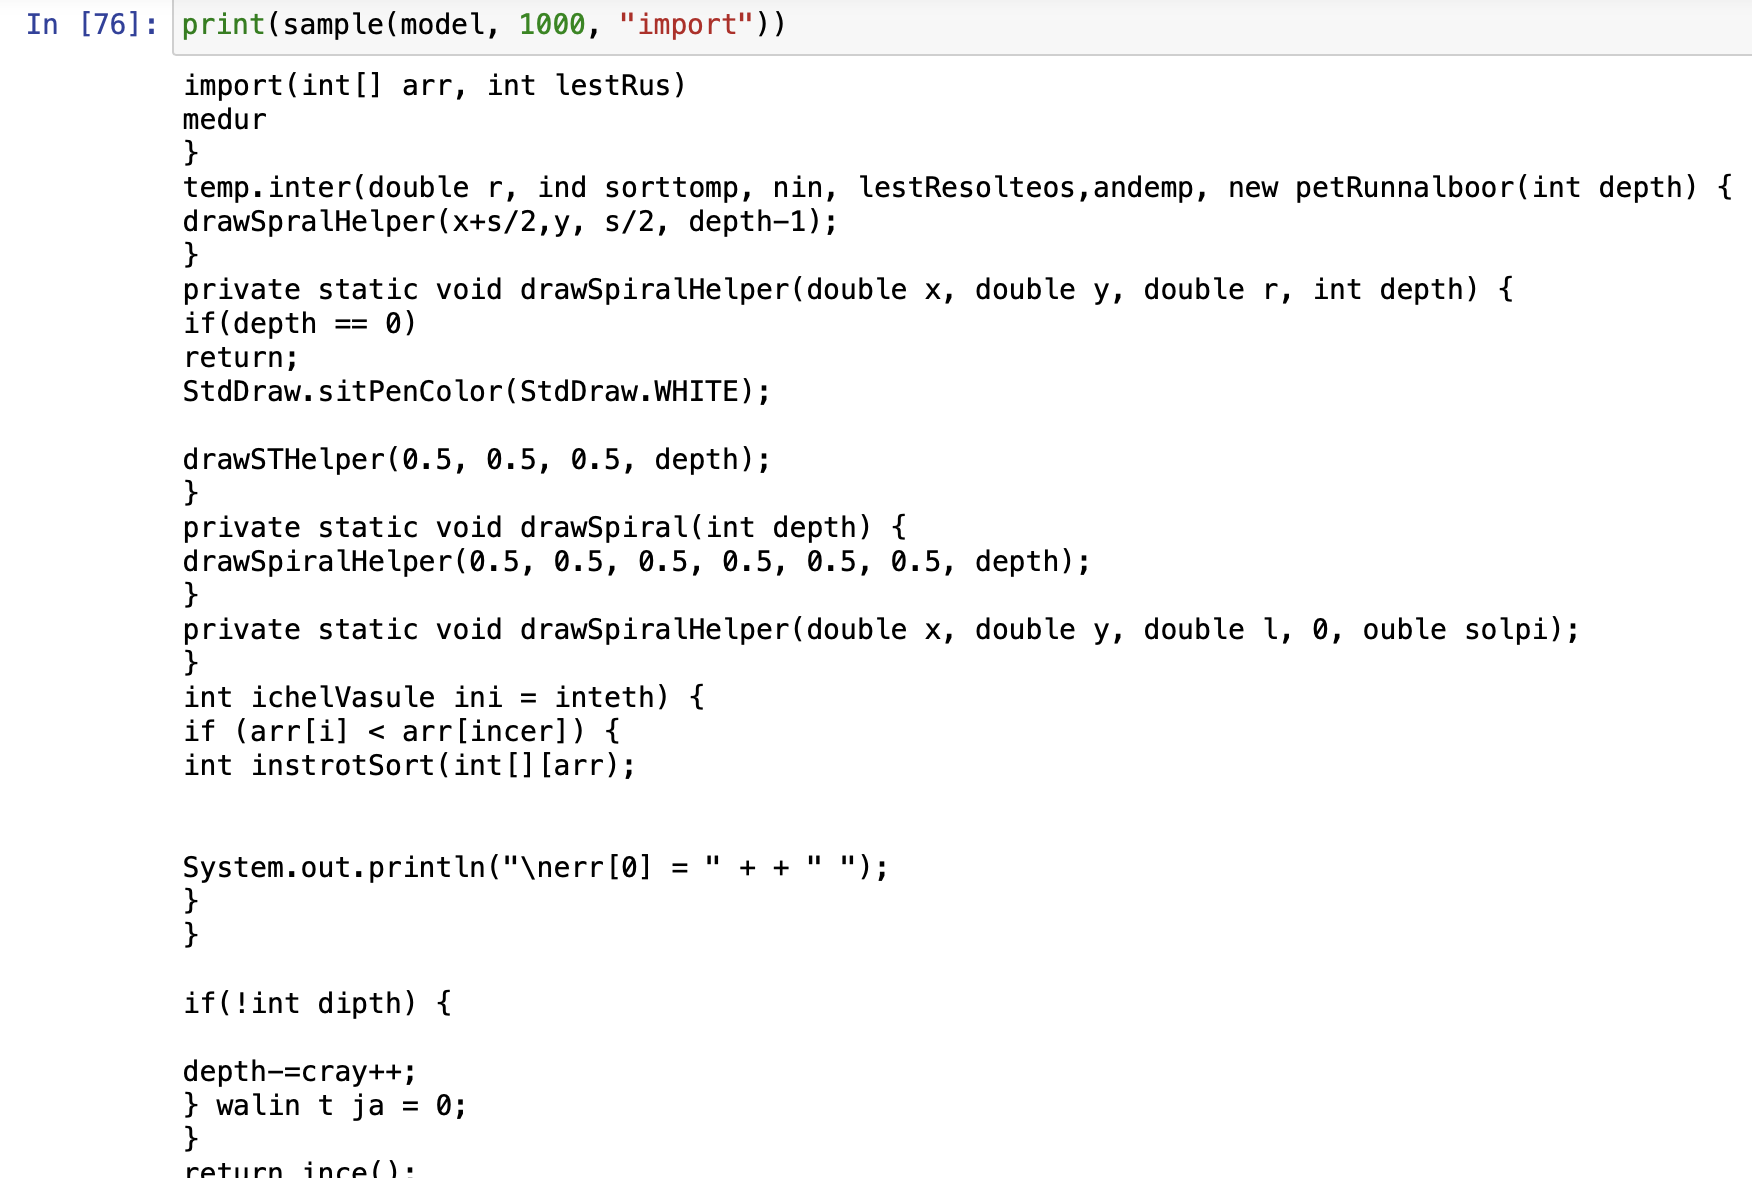

In [67]:
Image(filename=path+'10_epoch;len18423;lr=0.001.png') 

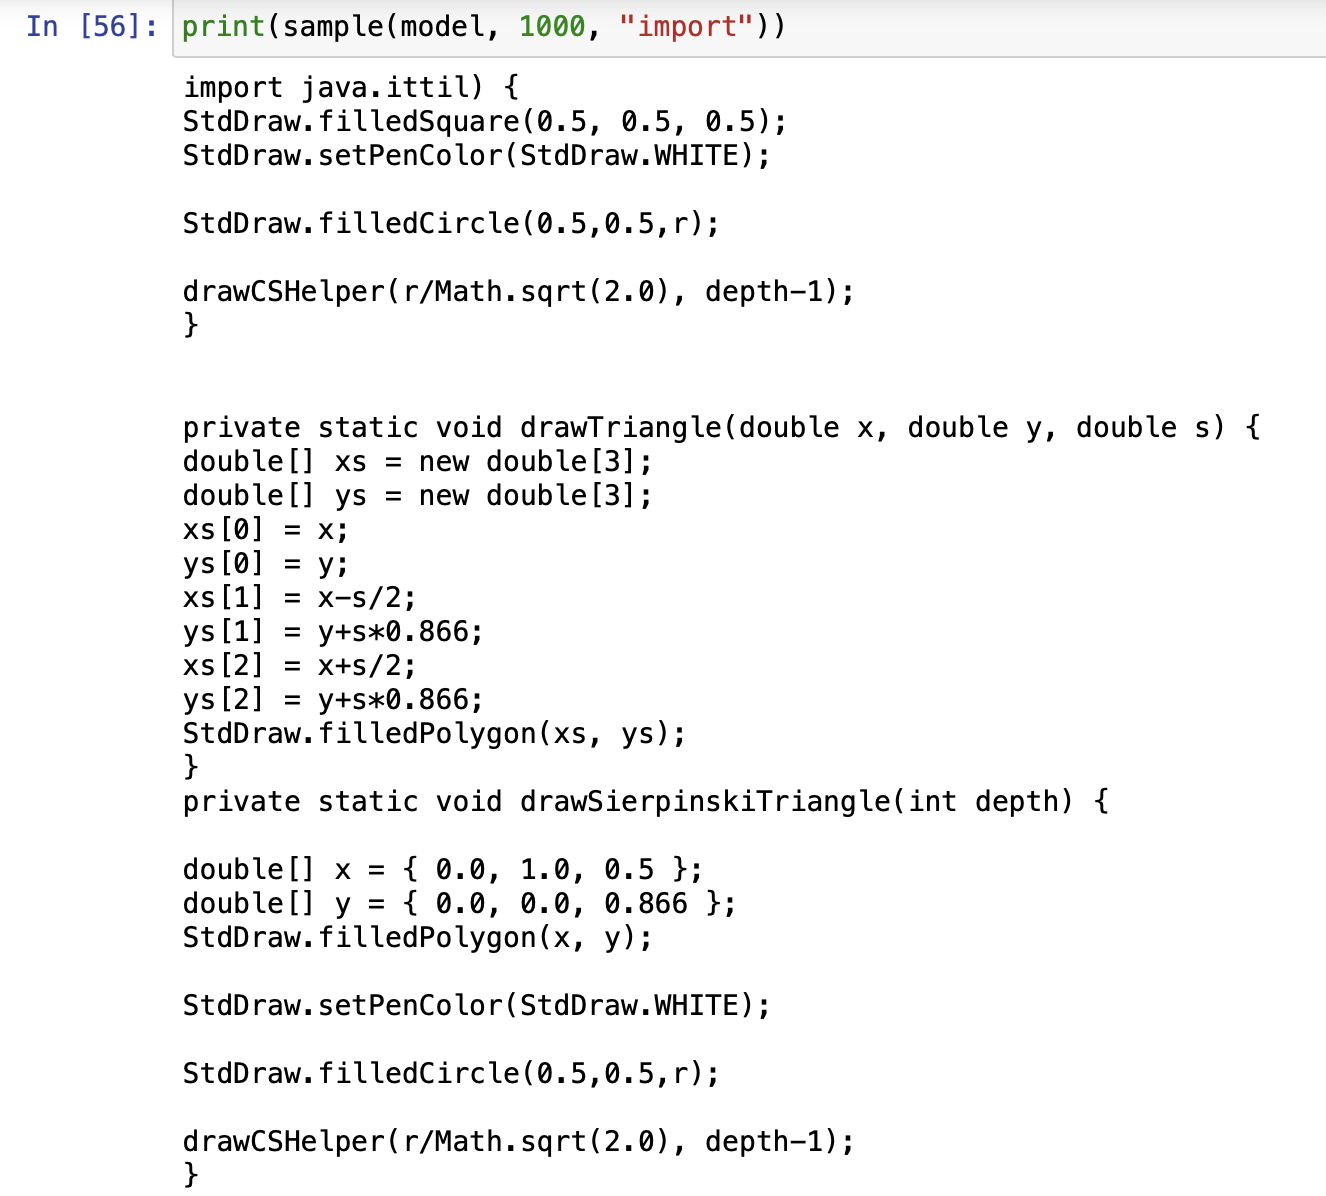

In [68]:
Image(filename=path+'20_epoch;len11997;lr=0.001.png')

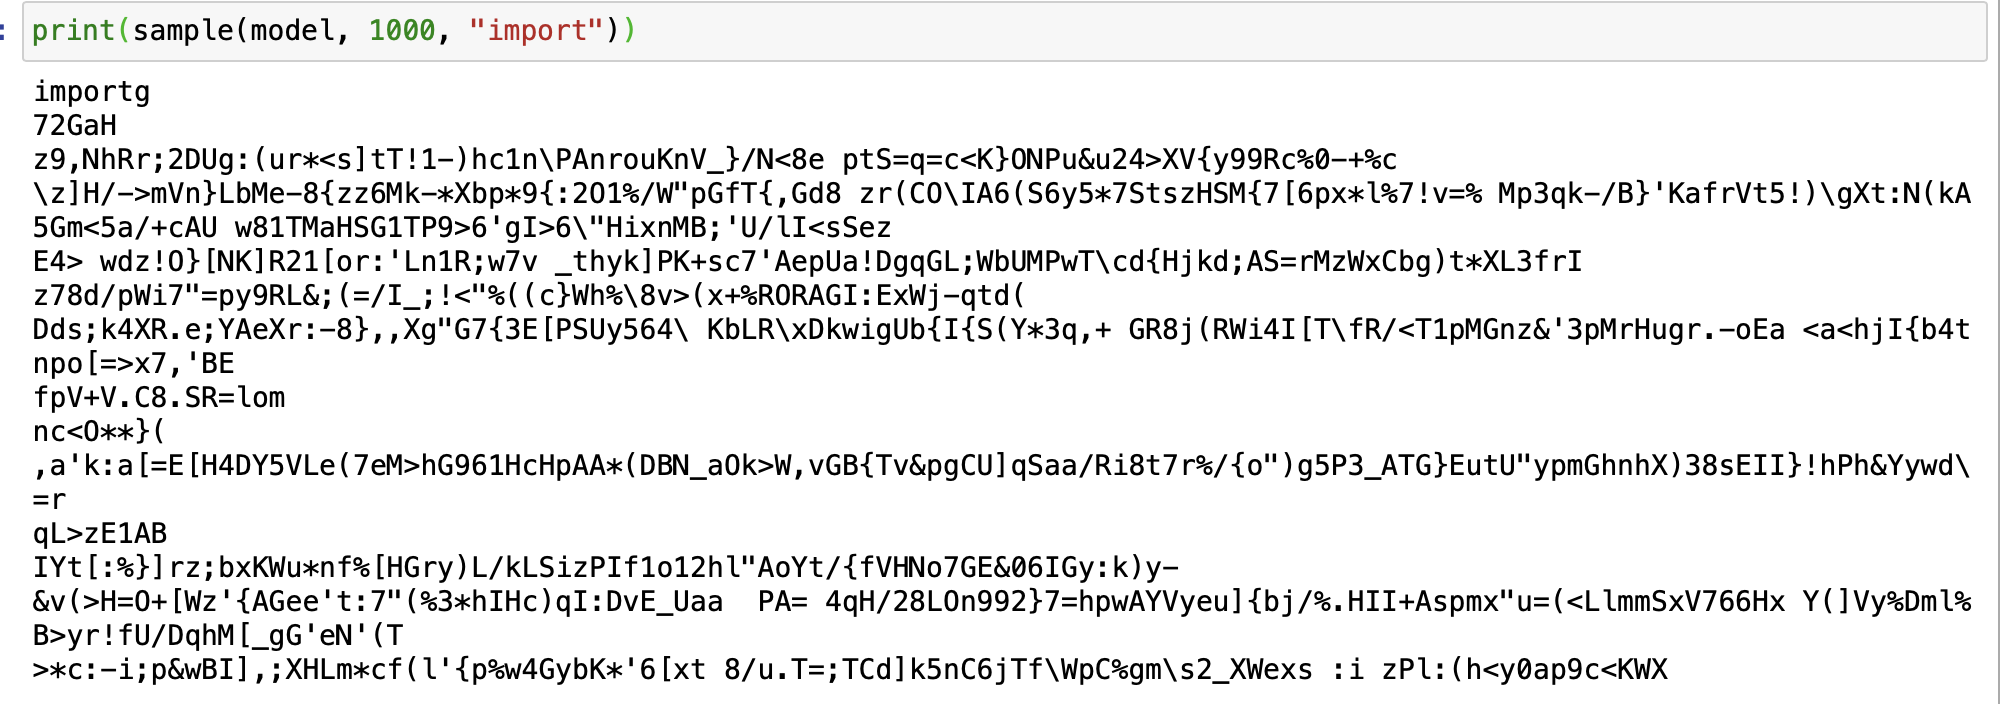

In [69]:
Image(filename=path+'10_epoch;len11997;lr=0.001;SGD.png')

As shown above I run my model with different parameters. The worst outcome was yielded with the model in which I used SGD as my loss function (last image); the ouput was not even close to java syntax. Then I changed my loss function to Adam. The number of characters in my corpus was 11997. I run my model with 10 epochs. Now the result was closer to actual Java syntax (first image). But still there were unreasonable lines and use of brackets were wrong. When I increased the number of characters in my corpus, I got better results; more accurate syntax (second image). But still there were mistakes in use of brackets and in syntax. I then increased the number of epochs to 20 (third image). Now I got a more reasonable result. The use of brackets were mostly correct. But there were mistakes like the first line (presumed import as a function). I then increased the number of epochs to 30 and I increased the number of charaacters in the corpus (since increasing both of them yielded better results). Now the syntax was mostly correct, the lines of codes made sense (the one that I run on the cell). But I then realized that this code is similar to the one in the corpus. So as I increase the number of epochs the result seems to be neater but it tends to overfit more.

Note: I removed spaces in my corpus, that's why spacing or indentation is not very good in the results. I wouldn't have removed spaces in my corpus if I were working with Python files; but spacing is not as important as in Python, so I removed spaces for this time. Similarly, I removed comments in my corpus to get clearer results. 